# Post-analysis of Spindles, SWR and Down-states.

Restart from SWR and spindles verified files. They are most likely the .csv files.

## Load events files and packages

In [46]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
import seaborn as sns
from pathlib import Path

from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[pos-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def Index_take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return 0
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return pos
    else:
        return (pos - 1)


sns.set(style="whitegrid", palette="muted")
%matplotlib widget

folder_base = Path('/Users/ahay/Documents/DATA/AHCR/Bleu/20240220')
filenameSp = folder_base / f'RSP_UDSproperties.csv'
filenameSwr = folder_base / f'pCOORDca1SWRproperties.csv'
filenameNW = folder_base / f'LFPwakeremoved.npy'
filenameAll = folder_base / f'RawDataChannelExtractedDS.npy'

#SpindlesS1 = pd.read_csv(filenameSp)
PFCspiprop = pd.read_csv(filenameSp)
SWRprop = pd.read_csv(filenameSwr)
#LFPwakeremoved = np.load(filenameNW, mmap_mode= 'r')
#All = np.load(filenameAll, mmap_mode= 'r')
#All = All.T
#PFC = All[:, 10]
#PFCwakeremoved = LFPwakeremoved[:, 10]


# determine the coupling of spindles/DS and swrs
400 ms for spindles and 200 ms for DS


In [47]:
# 400 ms for spindles and 200 ms for DS

before = 200 # ms
counterBefSpind = 0
counterDurSpind = 0
counterAftSpind = 0
BefCoupled_spindlesPFC = list()
BefunCoupled_spindlesPFC = list()
DurCoupled_spindlesPFC = list()
DurunCoupled_spindlesPFC = list()
AftCoupled_spindlesPFC = list()
AftunCoupled_spindlesPFC = list()


nb_spindle = PFCspiprop.shape[0]
print('total number of spindle/DS', nb_spindle)
for Pspin in range(nb_spindle):
    ser = pd.Series(PFCspiprop["start time"])
    ser2 = pd.Series(PFCspiprop["end time"])
    serSWR = pd.Series(SWRprop["peak time"])
    # prend le temps du peak du SWR le plus proche du prochain début de spindle/Down state
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    # mesure la distance entre le peak du SWR et le début du spindle/DS
    distance = Combined_Spindle_SWR - ser[Pspin]
    # défini la durée d'un spindle ###### UPDATED 26 OCTOBRE, POTENTIELLEMENT TOUS LES RESULTATS D'AVANT SONT FAUX
    after = ser2[Pspin] - ser[Pspin] #+ 200
# SWR occurring before spindle / DS
    if (distance > (- before)) and (distance <  0):
        counterBefSpind = counterBefSpind + 1
        BefCoupled_spindlesPFC.append(Pspin)
    else:
        BefunCoupled_spindlesPFC.append(Pspin)
    if (distance > (0)) and (distance <  after):
        counterDurSpind = counterDurSpind + 1
        DurCoupled_spindlesPFC.append(Pspin)
    else:
        DurunCoupled_spindlesPFC.append(Pspin)
    if (distance > (after)) and (distance < (after+200)):
        counterAftSpind = counterAftSpind + 1
        AftCoupled_spindlesPFC.append(Pspin)
    else:
        AftunCoupled_spindlesPFC.append(Pspin)

## Proportion of spindles/DR with SWR occurring before, during, Bef+Dur and After
print('Before spindle/DS', len(BefCoupled_spindlesPFC)/(len(BefCoupled_spindlesPFC)+len(BefunCoupled_spindlesPFC)), len(BefCoupled_spindlesPFC), len(BefunCoupled_spindlesPFC))
print('During spindle/DS', len(DurCoupled_spindlesPFC)/(len(DurCoupled_spindlesPFC)+len(DurunCoupled_spindlesPFC)), len(DurCoupled_spindlesPFC), len(DurunCoupled_spindlesPFC))
print('Before + During spindle/DS',  len(BefCoupled_spindlesPFC)/(len(BefCoupled_spindlesPFC)+len(BefunCoupled_spindlesPFC))+ len(DurCoupled_spindlesPFC)/(len(DurCoupled_spindlesPFC)+len(DurunCoupled_spindlesPFC)), len(BefCoupled_spindlesPFC) + len(DurCoupled_spindlesPFC), len(BefunCoupled_spindlesPFC) + len(DurunCoupled_spindlesPFC))

print('After DS', len(AftCoupled_spindlesPFC)/(len(AftCoupled_spindlesPFC)+len(AftunCoupled_spindlesPFC)), len(AftCoupled_spindlesPFC), len(AftunCoupled_spindlesPFC))



total number of spindle/DS 3677
Before spindle/DS 0.009790590155017678 36 3641
During spindle/DS 0.0013598041881968997 5 3672
Before + During spindle/DS 0.011150394343214578 41 7313
After DS 0.004895295077508839 18 3659


In [48]:
counterSWR = 0
Coupled_swr = list()
unCoupled_swr = list()
# 400 ms for spindles and 200 ms for DS
before = 200 # ms
counterBefSWR = 0
counterDurSWR = 0
counterAftSWR = 0
BefCoupled_swr = list()
BefunCoupled_swr = list()
DurCoupled_swr = list()
DurunCoupled_swr = list()
AftCoupled_swr = list()
AftunCoupled_swr = list()


nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]
print('total number of SWR', nb_swr)
for Pspin in range(nb_swr):
    ser = pd.Series(PFCspiprop["start time"])
    ser2 = pd.Series(PFCspiprop["end time"])
    serSWR = pd.Series(SWRprop["peak time"])
    # On prend le spindle/DS dont le début est le plus proche du peak du SWR
    Combined_Spindle_SWR = take_closest(ser, serSWR[Pspin])
    # On prend l'index du spindle dont le début est le plus proche du peak du SWR
    Combined_Spindle_SWR2 = Index_take_closest(ser, serSWR[Pspin])
    # On mesure la distance/DS entre le SWR et le début du spindle
    distance = Combined_Spindle_SWR - serSWR[Pspin]
    after = ser2[Combined_Spindle_SWR2] - ser[Combined_Spindle_SWR2]
    if (distance > (- before)) and (distance <  0):
        counterBefSWR = counterBefSWR + 1
        BefCoupled_swr.append(Pspin)
    else:
        BefunCoupled_swr.append(Pspin)
    if (distance > (0)) and (distance <  after):
        counterDurSWR = counterDurSWR + 1
        DurCoupled_swr.append(Pspin)
    else:
        DurunCoupled_swr.append(Pspin)
    if (distance > (after)) and (distance < (after+200)):
        counterAftSWR = counterAftSWR + 1
        AftCoupled_swr.append(Pspin)
    else:
        AftunCoupled_swr.append(Pspin)



## Proportion of SWR occurring before, during, Bef+Dur and After spindle/DS
print('Before spindle/DS', len(BefCoupled_swr)/(len(BefCoupled_swr)+len(BefunCoupled_swr)), len(BefCoupled_swr), len(BefunCoupled_swr))
print('During spindle/DS', len(DurCoupled_swr)/(len(DurCoupled_swr)+len(DurunCoupled_swr)), len(DurCoupled_swr), len(DurunCoupled_swr))
print('Before + During spindle/DS',  len(BefCoupled_swr)/(len(BefCoupled_swr)+len(BefunCoupled_swr))+ (len(DurCoupled_swr)/(len(DurCoupled_swr)+len(DurunCoupled_swr))), len(BefCoupled_swr) + len(DurCoupled_swr), nb_swr - len(BefCoupled_swr) - len(DurCoupled_swr))

print('After spindle/DS', len(AftCoupled_swr)/(len(AftCoupled_swr)+len(AftunCoupled_swr)), len(AftCoupled_swr), len(AftunCoupled_swr))


total number of SWR 273
Before spindle/DS 0.018315018315018316 5 268
During spindle/DS 0.1575091575091575 43 230
Before + During spindle/DS 0.1758241758241758 48 225
After spindle/DS 0.14285714285714285 39 234


In [ ]:
## JOUER AVANT DEF COUPLING SI BESOIN

filenameTTL = folder_base / f'timestamps.npy'
TTL = np.load(filenameTTL, mmap_mode= 'r')

TTLpropfake = []
TTLprop = []

for ic in TTL:
    ic2 = round(ic)
    if ic2 not in TTLpropfake:
        TTLpropfake.append(ic2)
        TTLprop.append(ic)

TTLprop2 = [i * 1000 for i in TTLprop]
TTLprop2 = [round(i) for i in TTLprop2]
TTLprop = pd.DataFrame(TTLprop2, columns = ['Start'])
filename3 = folder_base / f'TTLproperties.csv'
TTLprop.to_csv(filename3, sep = ',')


filenameTTL = folder_base / f'TTLproperties.csv'

TTLprop = pd.read_csv(filenameTTL)
TTLprop = TTLprop['Start']
TTLprop

number of events 

In [144]:
nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]

timesleeping = len(PFCwakeremoved)/1000
IncSpin =  nb_spindle/timesleeping
IncSWR =  nb_swr/timesleeping

print(IncSpin)
print(IncSWR)

1.1386434253576794
0.19104600230457913


event properties

In [8]:
print("SWR")
print(np.mean(SWRprop['Avg int']))
print(np.mean(SWRprop['Max int']))
print("Spindle")
print(np.mean(PFCspiprop['Avg int']))
print(np.mean(PFCspiprop['Max int']))


SWR
543.4060701203558
1390.6336996336997
Spindle
2205.443569553806
6589.816272965879


2205
Baseline: neg coupling 0.11; pos coupling 0.1; all coupling 0.22; inc spi 0.05 ev/sec; inc swr 0.19 ev/sec
            avg/max int swr 236/610; avg/max int spi 257/781
DCZ: neg coupling 0.12; pos coupling 0.09; all coupling: 0.21; inc spi 0.05 ev/sec; inc swr 0.21 ev/sec
            avg/max int swr 219/569; avg/max int spi 240/747

2206
Baseline: neg coupling 0.31; pos coupling 0.28; all coupling 0.59; inc spi 0.06 ev/sec; inc swr 0.56 ev/sec
            avg/max int swr 445/1142; avg/max int spi 2394/7232
DCZ: neg coupling 0.23; pos coupling 0.23; all coupling: 0.47; inc spi 0.04 ev/sec; inc swr 0.32 ev/sec
            avg/max int swr 413/1068; avg/max int spi 2221/6773

2207
Baseline: inc spi 0.043 ev/sec; 
            avg/max int spi 257/781
DCZ: inc spi 0.063 ev/sec;
            avg/max int spi 2119/6370

Histogramme de répartition des SWR around light stim

In [47]:
folder_base = Path('/Users/ahay/Documents/DATA/NecabChR2/Baseline5sec/EVIL/')
filenameTTL = folder_base / f'timestamps.npy'
TTL = np.load(filenameTTL, mmap_mode= 'r')

TTLpropfake = []
TTLprop = []

for ic in TTL:
    ic2 = round(ic)
    if ic2 not in TTLpropfake:
        TTLpropfake.append(ic2)
        TTLprop.append(ic)

TTLprop2 = [i * 1000 for i in TTLprop]
TTLprop2 = [round(i) for i in TTLprop2]
TTLprop = pd.DataFrame(TTLprop2, columns = ['Start'])
filename3 = folder_base / f'TTLproperties.csv'
TTLprop.to_csv(filename3, sep = ',')

filenameSp = folder_base / f'TTLproperties.csv'
filenameSwr = folder_base / f'CA1SWRproperties.csv'
PFCspiprop = pd.read_csv(filenameSp)
SWRprop = pd.read_csv(filenameSwr)
serSWR = pd.Series(SWRprop["peak time"])

counterPFC = 0
Distance_SWRstim = list()
nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]
whatareyou = list()

print(nb_spindle)
ser = pd.Series(PFCspiprop["Start"])


KeyError: 'peak time'

[33, 59, 62, 72, 218, 232, 252, 271, 288, 319, 345, 346, 360, 366, 375, 382, 410, 426, 429, 434, 461, 475, 562, 572, 646, 656, 669, 682, 726, 743, 744, 762, 763, 886, 918, 920, 936, 957, 965, 966, 972, 987, 1018, 1033, 1040, 1054, 1057]


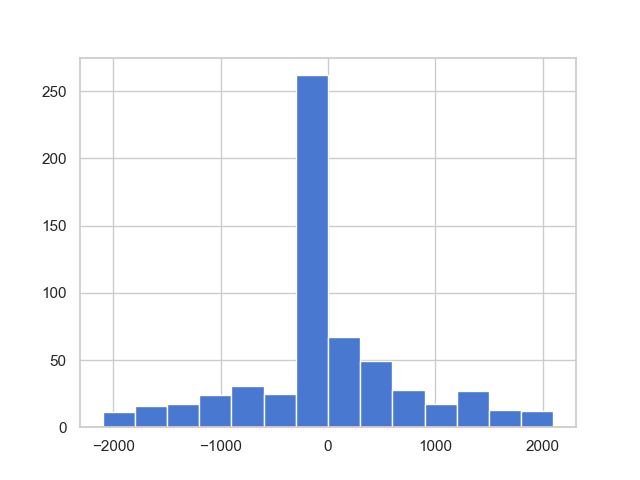

In [42]:
for Pspin in range(nb_spindle-100):
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if distance < 2100 and distance > -2100:
        Distance_SWRstim.append(distance)
    if distance < 200 and distance > 0:
        whatareyou.append(Pspin)
print(whatareyou)

plt.close() 
plt.hist(Distance_SWRstim, bins=[-2100, -1800, -1500, -1200, -900, -600, -300, 0, 300, 600, 900, 1200, 1500, 1800, 2100])
plt.show() 

In [34]:
len(Distance_SWRstim)
#Distance_SWRstim

802

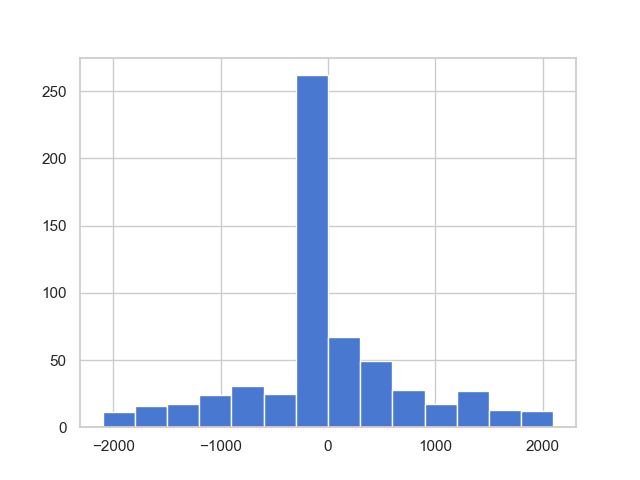

In [43]:

plt.close() 
plt.hist(Distance_SWRstim, bins=[-2100, -1800, -1500, -1200, -900, -600, -300, 0, 300, 600, 900, 1200, 1500, 1800, 2100])
#plt.hist(Distance_SWRstim, bins=[-2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000])
#plt.hist(Distance_SWRstim, bins=[-2100, -1400, -700, 0, 700, 1400, 2100])
plt.show() 

242 39


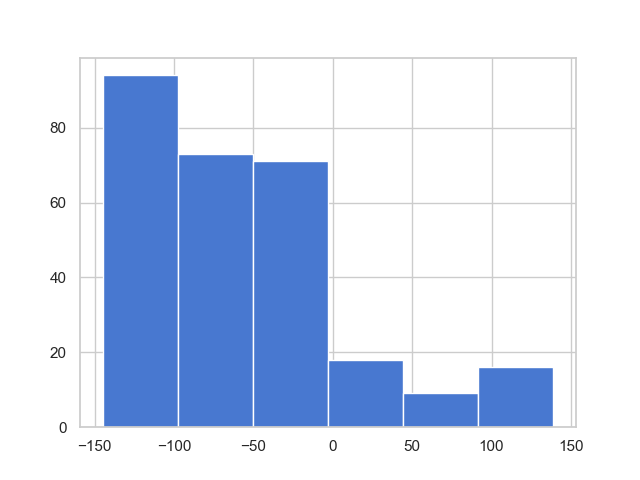

In [44]:
Distance_SWRstim2 = np.array(Distance_SWRstim)
Distance_SWRstim3 = Distance_SWRstim2[Distance_SWRstim2<150]
Distance_SWRstim4 = Distance_SWRstim3[Distance_SWRstim3>-150]
Distance_SWRstim5 = Distance_SWRstim4[Distance_SWRstim4>0]
Distance_SWRstim6 = Distance_SWRstim4[Distance_SWRstim4<0]
print(len(Distance_SWRstim6), len(Distance_SWRstim5))
plt.close() 
plt.hist(Distance_SWRstim4, bins=6)
plt.show() 

In [45]:
counterPFC = 0
Distance_stimSWR = list()
nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]

print(nb_swr)
for Pspin in range(nb_swr-100):
    ser = pd.Series(PFCspiprop["end time"])
    serSWR = pd.Series(SWRprop["peak time"])
    Combined_Spindle_SWR = take_closest(ser, serSWR[Pspin])
    distance = Combined_Spindle_SWR - serSWR[Pspin]
    Distance_stimSWR.append(distance)

print(len(Distance_stimSWR))

2903


KeyError: 'end time'

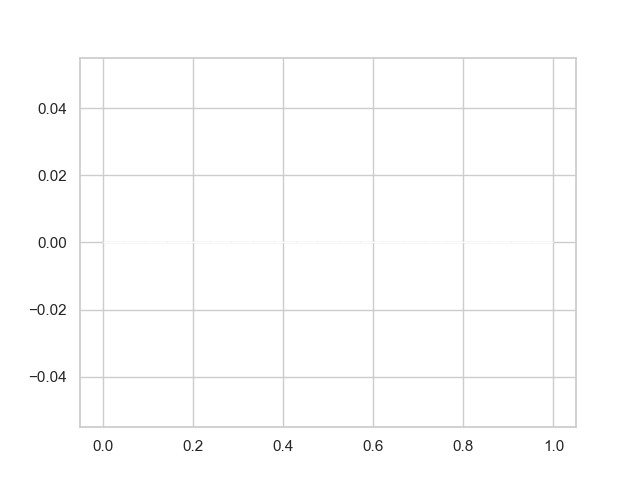

In [46]:
Distance_stimSWR2 = np.array(Distance_stimSWR)
Distance_stimSWR3 = Distance_stimSWR2[Distance_stimSWR2<500]
Distance_stimSWR4 = Distance_stimSWR3[Distance_stimSWR3>-500]

plt.close() 
plt.hist(Distance_stimSWR4, bins=21)
plt.show() 

2903
[101, 135, 162, 197, 229, 235, 241, 284, 288, 290, 299, 309, 327, 342, 351, 357, 436, 463, 493, 512, 516, 530, 532, 537, 552, 558, 563, 565, 569, 584, 585, 599, 600, 627, 632, 638, 643, 653, 657, 669, 689, 690, 695, 702, 709, 724, 737, 740, 753, 755, 760, 772, 784, 786, 809, 810, 814, 816, 822, 829, 830, 835, 843, 846, 865, 872, 875, 876, 877, 879, 883, 895, 914, 924, 929, 931, 939, 946, 954, 957, 964, 983, 994, 1004, 1011, 1018, 1020, 1025, 1029, 1032, 1037, 1038, 1040, 1048, 1049, 1055, 1058, 1066, 1075, 1080, 1087, 1090, 1095, 1108, 1115, 1121, 1123, 1143, 1145, 1161, 1168, 1169, 1178, 1179, 1180, 1202, 1204, 1209, 1224, 1227, 1244, 1255, 1256, 1266, 1274, 1282, 1292, 1293, 1305, 1325, 1329, 1339, 1345, 1349, 1359, 1376, 1380, 1386, 1393, 1397, 1404, 1408, 1433, 1437, 1442, 1448, 1451, 1456, 1472, 1475, 1478, 1479, 1487, 1491, 1498, 1506, 1511, 1514, 1522, 1537, 1544, 1553, 1572, 1589, 1597, 1606, 1631, 1646, 1651, 1665, 1674, 1675, 1680, 1681, 1685, 1689, 1690, 1696, 1699, 170

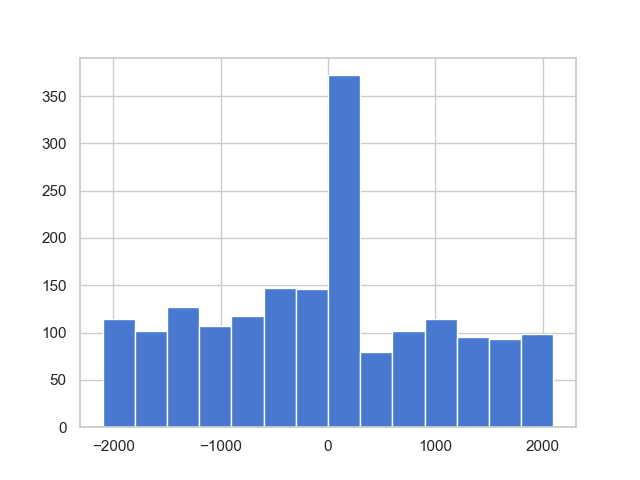

In [49]:
serSWR = pd.Series(SWRprop["Start"])

counterPFC = 0
Distance_SWRstim = list()
nb_spindle = PFCspiprop.shape[0]
nb_swr = SWRprop.shape[0]
whatareyou = list()

print(nb_spindle)
ser = pd.Series(PFCspiprop["peak time"])

for Pspin in range(nb_spindle-100):
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if distance < 2100 and distance > -2100:
        Distance_SWRstim.append(distance)
    if distance < 200 and distance > 0:
        whatareyou.append(Pspin)
print(whatareyou)

plt.close() 
plt.hist(Distance_SWRstim, bins=[-2100, -1800, -1500, -1200, -900, -600, -300, 0, 300, 600, 900, 1200, 1500, 1800, 2100])
plt.show() 

860 955


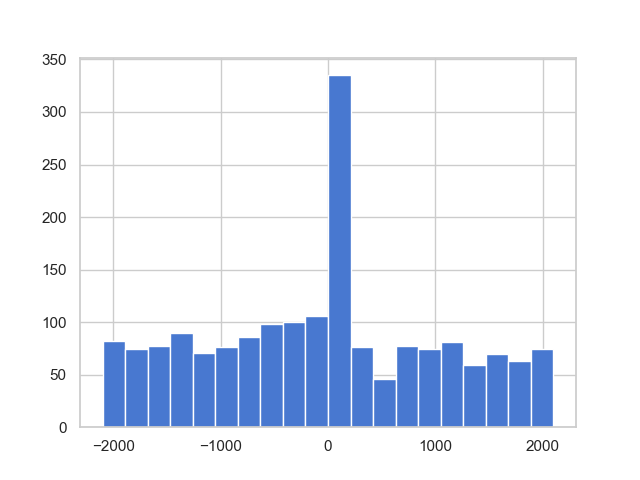

In [56]:
distance = 5000
binss = 20
Distance_SWRstim2 = np.array(Distance_SWRstim)
Distance_SWRstim3 = Distance_SWRstim2[Distance_SWRstim2<distance]
Distance_SWRstim4 = Distance_SWRstim3[Distance_SWRstim3>-distance]
Distance_SWRstim5 = Distance_SWRstim4[Distance_SWRstim4>0]
Distance_SWRstim6 = Distance_SWRstim4[Distance_SWRstim4<0]
print(len(Distance_SWRstim6), len(Distance_SWRstim5))
plt.close() 
plt.hist(Distance_SWRstim4, bins=binss)
plt.show() 

In [ ]:
SWRprop
SWRprop.describe()
r = np.corrcoef(SWRprop['Duration'], SWRprop['Avg int'])
r[0, 1] # -0.1757 No correlation!
r = np.corrcoef(SWRprop['Avg freq'], SWRprop['Avg int'])
r[0, 1] # 0.2528 No correlation!
r = np.corrcoef(SWRprop['Avg freq'], SWRprop['Duration'])
r[0, 1] # -0.2478 No correlation!

fig, ax = plt.subplots()
ax.plot(SWRprop['Duration'], SWRprop['Avg int'], marker='o', linewidth=0)
ax.set_title('correlation Duration - Intensity')
ax.set_xlabel('Duration (ms)')
ax.set_ylabel('Intensity (AU)')
